<a href="https://colab.research.google.com/github/alexvaroz/ProjetoBR319/blob/master/Processamento_Vetores_Geo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook tem o objetivo de concentrar os códigos desenvolvidos para a manipulação dos arquivos `shapefile` utilizados no projeto **"Caracterização do uso e ocupação do solo na área de influência da BR-319"**.

Abaixo, algumas referências consultadas:

https://towardsdatascience.com/looking-for-patterns-in-satellite-image-time-series-with-python-de097f4065d7

https://towardsdatascience.com/automating-gis-and-remote-sensing-workflows-with-open-python-libraries-e71dd6b049ee

https://towardsdatascience.com/reading-and-visualizing-geotiff-images-with-python-8dcca7a74510

In [1]:
# Instalação das bibliotecas necessárias
!pip install geemap -q
!pip install earthengine-api -q
!pip install geopandas -q
!pip install earthpy -q 
!pip install pygeos -q

     |████████████████████████████████| 2.1 MB 3.8 MB/s 
     |████████████████████████████████| 1.3 MB 42.7 MB/s 
     |████████████████████████████████| 3.7 MB 43.8 MB/s 
     |████████████████████████████████| 3.5 MB 39.6 MB/s 
     |████████████████████████████████| 198 kB 49.4 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 98 kB 7.0 MB/s 
     |████████████████████████████████| 130 kB 25.3 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 99 kB 4.5 MB/s 
     |████████████████████████████████| 1.2 MB 43.1 MB/s 
     |████████████████████████████████| 128 kB 49.5 MB/s 
     |████████████████████████████████| 1.6 MB 22.4 MB/s 
     |████████████████████████████████| 79 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 3.8 MB/s 
     |████████████████████████████████| 16.6 MB 53.6 MB/s 
     |████████████████████████████████| 7.8 MB 50.0 MB/s 
     |███████████████████

In [ ]:
# Integração com o google earth engine para utilização de arquivos
# disponibilizados lá

import ee

ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=9ghzcQ3ew5V0GEFm-3MVkPwUEnPnp16cRBdrapftC5c&tc=BFId1-n2_hd1GXdfL679t_UC6O-nqKjb_lRjhOpAXF4&cc=liLS4ODmYLln2_ncDcFv1ABmSceWni1hF5JdqRz_RvM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvvYbZP6mUCjZK4zt9fZnWjvxG7_W4PRkiogfNhAdp1UFBdK9HGd-iY

Successfully saved authorization token.


In [ ]:
# Importação das bibliotecas
import ee
import pandas as pd
import numpy as np
import geopandas as gpd
import pygeos
import geemap
from rasterio.mask import mask
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from fiona.crs import from_epsg
import pycrs

ee.Initialize()

In [ ]:
# Carregamento dos ativos disponíveis no ambiente google earth engine

buffer50 = ee.FeatureCollection('projects/ee-alexandrepy/assets/buffer50')
alap = ee.FeatureCollection('projects/ee-alexandrepy/assets/alap_319')
tis = ee.FeatureCollection('projects/ee-alexandrepy/assets/MAPBIOMAS/indigenous_area_legal_amazon')
ucs = ee.FeatureCollection('projects/ee-alexandrepy/assets/conservation_units_legal_amazon')
assAM = ee.FeatureCollection('projects/ee-alexandrepy/assets/AssentamentoFederal_AM')
assRO = ee.FeatureCollection('projects/ee-alexandrepy/assets/AssentamentoFederal_RO')
municipios = gpd.read_file('/content/drive/MyDrive/MAPBIOMAS-EXPORT/municipalities_legal_amazon.zip')

In [ ]:
# Transformação dos shapefiles em GeoDataFrame para operação com o Geopandas
buffer50_pd = geemap.ee_to_geopandas(buffer50)
alap_pd = geemap.ee_to_geopandas(alap)
tis_pd = geemap.ee_to_geopandas(tis)
ucs_pd = geemap.ee_to_geopandas(ucs)
assAM_pd = geemap.ee_to_geopandas(assAM)
assRO_pd = geemap.ee_to_geopandas(assRO)

In [ ]:
# Definição do CRS para a operação de recorte (clipagem)
ucs_pd_crs_4674 = ucs_pd.set_crs({'init': 'epsg:4674'})
alap_pd_crs_4674 = alap_pd.set_crs({'init': 'epsg:4674'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
ucs_cliped_alap_crs_4674 = gpd.clip(ucs_pd_crs_4674, alap_pd_crs_4674)

In [ ]:
result_crs_4674 = pd.read_csv('/content/zonal_stats_by_group.csv')

In [ ]:
result_crs_4674.columns

NameError: ignored

In [ ]:
result_crs_4674.Class_1.values + result_crs_4674.Class_49.values 

AttributeError: ignored

In [ ]:
tis_cliped_alap = gpd.clip(tis_pd, alap_pd)

In [ ]:
tis_cliped_alap = gpd.clip(tis_pd, alap_pd)
ucs_cliped_alap = gpd.clip(ucs_pd, alap_pd)
assAM_cliped_alap = gpd.clip(assAM_pd, alap_pd)
assRO_cliped_alap = gpd.clip(assRO_pd, alap_pd)
municipios_alap = gpd.clip(municipios, alap_pd)

tis_cliped_buffer = gpd.clip(tis_pd, buffer50_pd)
ucs_cliped_buffer = gpd.clip(ucs_pd, buffer50_pd)
assAM_cliped_buffer = gpd.clip(assAM_pd, buffer50_pd)
assRO_cliped_buffer = gpd.clip(assRO_pd, buffer50_pd)
municipios_buffer = gpd.clip(municipios, buffer50_pd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: None

  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: None

  # This is added back by InteractiveShellApp.init_path()


In [ ]:
raster_alap = 'projects/ee-alexandrepy/assets/ALAP319-2021'

In [ ]:
dataset = ee.Image(raster_alap)

AttributeError: ignored

In [ ]:
dataset = ee.Image(raster_alap)
landcover = ee.Image(dataset.select('b1'))

In [ ]:
dataset = ee.Image(raster_alap)
landcover = ee.Image(dataset.select('b1'))
ucs_cliped_alap.set_crs(epsg = "4674", inplace = True)
mun_alap = geemap.geopandas_to_ee(ucs_cliped_alap)

result_zonal = geemap.zonal_statistics_by_group(
    landcover,
    mun_alap,
    statistics_type='SUM',
    denominator=1000000,
    decimal_places=2,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /content/zonal_stats_by_group.csv


In [ ]:
df = pd.read_csv('/content/zonal_stats_by_group.csv')

In [ ]:
df.head()

,Class_30,Class_31,Class_10,Class_32,Class_11,Class_33,Class_sum,Class_8,Class_12,Class_34,...,Class_27,Class_28,Class_29,system:index,esfera,ano_cria,categoria,grupo,nome,id
0,0.0,0.00,0.19,0.00,0.05,0.0,3.56,0.15,0.00,0.00,...,0.07,0.00,0.00,0,estadual,1990,Estação Ecológica,PI,ESTAÇÃO ECOLÓGICA SERRA DOS TRÊS IRMÃOS,1429
1,0.0,0.00,3.07,0.00,2.72,0.0,866.08,2.85,2.00,0.00,...,0.05,0.00,0.00,1,federal,2008,Floresta,US,FLORESTA NACIONAL DO IQUIRI,1594
2,0.0,0.00,3.94,0.00,5.04,0.0,170.19,1.48,22.16,0.00,...,0.00,0.00,0.03,2,federal,2001,Estação Ecológica,PI,ESTAÇÃO ECOLÓGICA DE CUNIÃ,1458
3,0.8,0.62,80.72,0.88,101.02,0.8,10532.01,66.92,256.78,0.35,...,1.24,0.97,0.97,3,federal,2008,Parque,PI,PARQUE NACIONAL MAPINGUARI,1190
4,0.0,0.00,0.00,0.00,0.00,0.0,12.96,0.03,0.05,0.00,...,0.00,0.00,0.00,4,estadual,1996,Floresta,US,FLORESTA ESTADUAL DE RENDIMENTO SUSTENTADO DO ...,217


In [ ]:
df.Class_24.sum()

54.019999999999996

In [ ]:
df.drop(columns=['system:index', 'esfera', 'ano_cria', 'categoria', 'grupo',
       'nome', 'Class_sum'], inplace=True)

In [ ]:
df.head()

,Class_30,Class_31,Class_10,Class_32,Class_11,Class_33,Class_8,Class_12,Class_34,Class_7,...,Class_21,Class_22,Class_23,Class_24,Class_25,Class_26,Class_27,Class_28,Class_29,id
0,0.0,0.00,0.19,0.00,0.05,0.0,0.15,0.00,0.00,0.14,...,0.00,0.00,0.00,0.00,0.0,0.08,0.07,0.00,0.00,1429
1,0.0,0.00,3.07,0.00,2.72,0.0,2.85,2.00,0.00,3.24,...,0.00,0.05,0.09,0.09,0.0,0.00,0.05,0.00,0.00,1594
2,0.0,0.00,3.94,0.00,5.04,0.0,1.48,22.16,0.00,1.93,...,0.03,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.03,1458
3,0.8,0.62,80.72,0.88,101.02,0.8,66.92,256.78,0.35,72.83,...,2.45,1.68,2.00,1.59,1.5,0.88,1.24,0.97,0.97,1190
4,0.0,0.00,0.00,0.00,0.00,0.0,0.03,0.05,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,217


In [ ]:
df.columns

Index(['Class_30', 'Class_31', 'Class_10', 'Class_32', 'Class_11', 'Class_33',
       'Class_8', 'Class_12', 'Class_34', 'Class_7', 'Class_13', 'Class_35',
       'Class_14', 'Class_36', 'Class_9', 'Class_15', 'Class_37', 'Class_16',
       'Class_38', 'Class_17', 'Class_39', 'Class_18', 'Class_19', 'Class_0',
       'Class_2', 'Class_1', 'Class_4', 'Class_3', 'Class_6', 'Class_5',
       'Class_40', 'Class_41', 'Class_20', 'Class_21', 'Class_22', 'Class_23',
       'Class_24', 'Class_25', 'Class_26', 'Class_27', 'Class_28', 'Class_29',
       'id'],
      dtype='object')

In [ ]:
df = pd.melt(df.reset_index(), var_name='class', 
id_vars='id', value_name='area')

In [ ]:
df.head()

,id,class,area
0,1429,index,0.0
1,1594,index,1.0
2,1458,index,2.0
3,1190,index,3.0
4,217,index,4.0


In [ ]:
df[df['class']=='Class_4']['area'].sum()

977.46

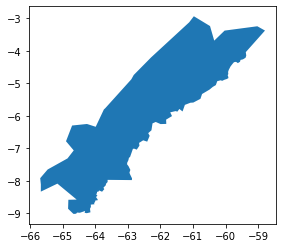

In [ ]:
alap_pd.plot()

In [ ]:
alap_pd.set_crs(epsg=4326, inplace=True)
alap_pd["area_km2"] = alap_pd['geometry'].area

In [ ]:
alap_pd

,geometry,area_km2
0,"POLYGON ((-65.69182 -7.91672, -65.67156 -8.106...",12.760232


In [ ]:
df.head(10)

,Class_30,Class_31,Class_10,Class_32,Class_11,Class_33,Class_sum,Class_8,Class_12,Class_34,...,Class_24,Class_25,Class_26,Class_27,Class_28,Class_29,system:index,geocodigo,id,nome
0,0.05,0.00,1.96,0.00,1.15,0.06,59.46,1.71,3.22,0.00,...,0.00,0.00,0.07,0.06,0.08,0.00,0,1100205,2222,Porto Velho
1,4.45,4.03,95.45,5.49,97.41,11.64,14527.22,95.17,207.62,0.27,...,13.29,8.76,6.35,9.05,6.81,6.54,1,1302405,647,Lábrea
2,7.20,7.80,148.40,10.62,163.72,155.22,9432.86,154.56,250.46,0.09,...,12.63,6.20,7.22,7.43,6.45,6.75,2,1301704,2244,Humaitá
3,12.79,10.47,191.91,11.53,218.37,54.28,31208.43,184.52,422.76,0.35,...,10.47,9.49,9.99,8.21,9.69,9.14,3,1300904,865,Canutama
4,1.68,2.41,8.38,2.40,6.08,52.81,1116.20,10.77,7.66,0.00,...,2.11,1.59,2.06,1.52,2.13,1.42,4,1303304,924,Novo Aripuanã
5,12.06,11.75,86.93,14.07,93.89,264.38,16747.78,103.41,202.79,0.00,...,9.37,9.96,7.65,8.46,9.00,10.25,5,1302702,587,Manicoré
6,17.92,17.98,80.34,19.63,81.05,299.47,13055.79,100.86,108.77,0.00,...,22.13,21.58,20.62,18.82,17.54,18.25,6,1300805,858,Borba
7,33.44,32.96,84.03,42.29,82.56,462.74,17210.84,102.19,128.73,0.00,...,31.36,27.86,30.68,26.42,28.64,28.79,7,1300631,511,Beruri
8,0.34,0.09,0.30,0.61,0.36,10.00,26.95,0.47,0.45,0.00,...,0.45,0.05,0.18,0.09,0.07,0.44,8,1303106,861,Nova Olinda do Norte
9,49.42,53.11,139.34,58.25,141.38,409.67,7400.26,153.90,164.16,0.00,...,44.09,42.71,41.85,39.85,47.32,47.74,9,1300300,863,Autazes


In [ ]:
df.Class_sum.sum()

156235.55

In [ ]:
Map = geemap.Map()
Map.add_raster(raster_alap, colormap='terrain', layer_name='DEM')
Map

In [ ]:
buffer50 = ee.FeatureCollection('projects/ee-alexandrepy/assets/buffer50')
alap = ee.FeatureCollection('projects/ee-alexandrepy/assets/alap_319')
tis = ee.FeatureCollection('projects/ee-alexandrepy/assets/MAPBIOMAS/indigenous_area_legal_amazon')
ucs = ee.FeatureCollection('projects/ee-alexandrepy/assets/conservation_units_legal_amazon')
assAM = ee.FeatureCollection('projects/ee-alexandrepy/assets/AssentamentoFederal_AM')
assRO = ee.FeatureCollection('projects/ee-alexandrepy/assets/AssentamentoFederal_RO')

In [ ]:
municipios = gpd.read_file('/content/drive/MyDrive/MAPBIOMAS-EXPORT/municipalities_legal_amazon.zip')

In [ ]:
municipios.head()

,id,nome,geocodigo,anoderefer,geometry
0,19,Tesouro,5108105,None,"POLYGON ((-53.05788 -15.96060, -53.06003 -15.9..."
1,30,Nova Brasilândia,5106208,None,"POLYGON ((-54.69848 -14.95350, -54.70283 -14.9..."
2,39,Torixoréu,5108204,None,"POLYGON ((-52.47125 -16.12639, -52.47301 -16.1..."
3,280,Várzea Grande,5108402,None,"POLYGON ((-56.35519 -15.41263, -56.35512 -15.4..."
4,285,Curvelândia,5103437,None,"POLYGON ((-57.79789 -15.76679, -57.79843 -15.7..."


In [ ]:
buffer50_pd = geemap.ee_to_geopandas(buffer50)
alap_pd = geemap.ee_to_geopandas(alap)
tis_pd = geemap.ee_to_geopandas(tis)
ucs_pd = geemap.ee_to_geopandas(ucs)
assAM_pd = geemap.ee_to_geopandas(assAM)
assRO_pd = geemap.ee_to_geopandas(assRO)

In [ ]:
tis_cliped_alap = gpd.clip(tis_pd, alap_pd)
ucs_cliped_alap = gpd.clip(ucs_pd, alap_pd)
assAM_cliped_alap = gpd.clip(assAM_pd, alap_pd)
assRO_cliped_alap = gpd.clip(assRO_pd, alap_pd)
municipios_alap = gpd.clip(municipios, alap_pd)

tis_cliped_buffer = gpd.clip(tis_pd, buffer50_pd)
ucs_cliped_buffer = gpd.clip(ucs_pd, buffer50_pd)
assAM_cliped_buffer = gpd.clip(assAM_pd, buffer50_pd)
assRO_cliped_buffer = gpd.clip(assRO_pd, buffer50_pd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: None

  """


In [ ]:
municipios_alap.plot()

NameError: ignored

In [ ]:
ucs_cliped_alap

,geometry,ano_cria,categoria,esfera,grupo,id,nome
98,"MULTIPOLYGON (((-64.66364 -9.01151, -64.65718 ...",1990,Estação Ecológica,estadual,PI,1429,ESTAÇÃO ECOLÓGICA SERRA DOS TRÊS IRMÃOS
144,GEOMETRYCOLLECTION (POLYGON ((-65.24387 -7.789...,2008,Floresta,federal,US,1594,FLORESTA NACIONAL DO IQUIRI
45,"MULTIPOLYGON (((-63.80015 -8.32843, -63.80702 ...",2001,Estação Ecológica,federal,PI,1458,ESTAÇÃO ECOLÓGICA DE CUNIÃ
1,"MULTIPOLYGON (((-64.68027 -9.00384, -64.68246 ...",2008,Parque,federal,PI,1190,PARQUE NACIONAL MAPINGUARI
236,"MULTIPOLYGON (((-63.93849 -8.55584, -63.94520 ...",1996,Floresta,estadual,US,217,FLORESTA ESTADUAL DE RENDIMENTO SUSTENTADO DO ...
172,"POLYGON ((-65.65418 -8.14275, -65.64844 -8.136...",2008,Reserva Extrativista,federal,US,368,RESERVA EXTRATIVISTA ITUXí
157,"MULTIPOLYGON (((-64.83439 -7.29127, -64.83388 ...",2008,Reserva Extrativista,federal,US,40,RESERVA EXTRATIVISTA DO MéDIO PURúS
151,GEOMETRYCOLLECTION (LINESTRING (-64.33393 -6.5...,2005,Floresta,federal,US,465,FLORESTA NACIONAL DE BALATA-TUFARI
276,"POLYGON ((-64.80039 -6.86980, -64.79956 -6.867...",2009,Reserva Extrativista,estadual,US,1714,RESERVA EXTRATIVISTA CANUTAMA
235,"POLYGON ((-64.25840 -6.25431, -64.25946 -6.255...",2009,Floresta,estadual,US,154,FLORESTA ESTADUAL CANUTAMA


In [ ]:
ucs_cliped_alap.to_csv('ucs_cliped_alap.csv', index= False)
tis_cliped_alap.to_csv('tis_cliped_alap.csv', index= False)
assAM_cliped_alap.to_csv('assAM_cliped_alap.csv', index= False)
assRO_cliped_alap.to_csv('assRO_cliped_alap.csv', index= False)
municipios_alap.to_csv('municipios_cliped_alap.csv', index= False)

ucs_cliped_buffer.to_csv('ucs_cliped_buffer.csv', index= False)
tis_cliped_buffer.to_csv('tis_cliped_buffer.csv', index= False)
assAM_cliped_buffer.to_csv('assAM_cliped_buffer.csv', index= False)
assRO_cliped_buffer.to_csv('assRO_cliped_buffer.csv', index= False)

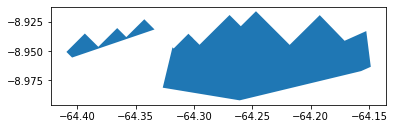

In [ ]:
assRO_cliped_alap.plot()

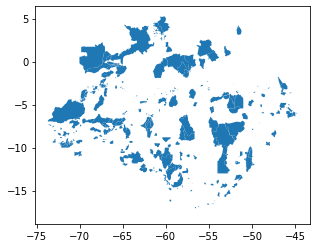

In [ ]:
tis_pd.plot()

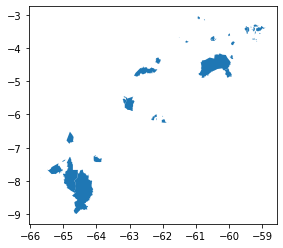

In [ ]:
tis_cliped = gpd.clip(tis_pd, alap_pd)
tis_cliped.plot()

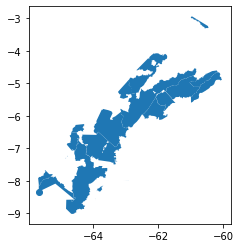

In [ ]:
ucs_cliped = gpd.clip(ucs_pd, alap_pd)
ucs_cliped.plot()

In [ ]:
ucs_cliped_alap.to_csv('ucs_cliped_alap.csv', index= False)
tis_cliped_alap.to_csv('tis_cliped_alap.csv', index= False)
assAM_cliped_alap.to_csv('assAM_cliped_alap.csv', index= False)
assRO_cliped_alap.to_csv('assRO_cliped_alap.csv', index= False)

ucs_cliped_buffer.to_csv('ucs_cliped_buffer.csv', index= False)
tis_cliped_buffer.to_csv('tis_cliped_buffer.csv', index= False)
assAM_cliped_buffer.to_csv('assAM_cliped_buffer.csv', index= False)
assRO_cliped_buffer.to_csv('assRO_cliped_buffer.csv', index= False)


In [ ]:
ucs_cliped.to_csv('ucs_cliped.csv')

In [ ]:
envelope = tis_cliped.geometry.total_bounds
aoi=ee.Geometry.Rectangle(envelope.tolist())

In [ ]:
tis_cliped.to_file("tis_cliped.geojson", driver='GeoJSON')

In [ ]:
fp = r"/content/drive/MyDrive/MAPBIOMAS-EXPORT/ALAP319-2021.tif"
out_tif = r"/content/drive/MyDrive/MAPBIOMAS-EXPORT/ALAP319-2021_cliped.tif"

In [ ]:
data = rasterio.open(fp)

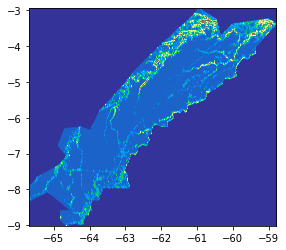

In [ ]:
show((data, 1), cmap='terrain')

In [ ]:
out_img, out_transform = mask(data, tis_cliped.geometry, invert=False)

In [ ]:
type(out_transform)

affine.Affine

In [ ]:
out_meta = data.meta.copy()

In [ ]:
epsg_code = int(data.crs.data['init'][5:])

In [ ]:
print(epsg_code)

4326


In [ ]:
out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                    )

In [ ]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
  dest.write(out_img)

In [ ]:
import matplotlib.colors
clipped = rasterio.open(out_tif)
levels = [3, 4, 5, 9, 11, 12, 13, 15, 20, 21, 23, 24, 25, 29, 30, 31, 34, 33, 
          39, 40, 41, 46, 47, 48, 49 ]

clrs = ["#006400", "#00ff00", "#687537", "#ad4413", "#45c2a5", "#b8af4f", 
        "#f1c232", "#ffd966", "#c27ba0", "#fff3bf", "#dd7e6b", "#aa0000", 
        "#ff3d3d", "#665a3a", "#af2a2a", "#02106f", "#968c46", "#0000ff", 
        "#e075ad", "#982c9e", "#e787f8", "#cca0d4", "#d082de", "#cd49e4", 
        "#6b9932" ]

cmap, norm = matplotlib.colors.from_levels_and_colors(levels, clrs,extend='max')


show((clipped, 1), cmap=cmap)

In [ ]:
imagem_alap = ee.ImageCollection('projects/ee-alexandrepy/assets/AMAZONIA-LEGAL-2021')

In [ ]:
mapbiomas = ee.Image('projects/ee-alexandrepy/assets/AMAZONIA-LEGAL-2021').select('b1').clip(aoi)

In [ ]:
from IPython.display import Image
parameters = {'min': 0,
              'max': 10,
              'dimensions': 512,
              'region': aoi}

Image(url = mapbiomas.getThumbUrl(parameters))

TypeError: ignored

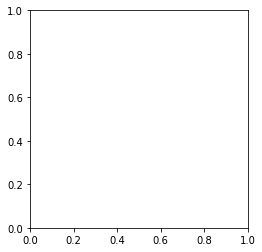

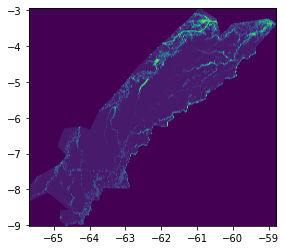

In [ ]:
fp = r'/content/drive/MyDrive/MAPBIOMAS-EXPORT/ALAP319-2021.tif'
img = rasterio.open(fp)
show(img)

In [ ]:
mapbiomas

In [ ]:
from IPython.display import Image
parameters = {'min': 0,
              'max': 33,
              'dimensions': 512,
              'region': mapbiomas}

Image(url = mapbiomas.getThumbUrl(parameters))

EEException: ignored

In [ ]:
points_clip = gpd.clip(tis_pd, alap_pd)
tis_clip = geemap.geopandas_to_ee(points_clip)

ValueError: ignored

In [ ]:
#Import the libraries
import pprint
import rasterio
from rasterio import features
from shapely.geometry import shape

#Open the MapBiomas export
with rasterio.open('/content/drive/MyDrive/MAPBIOMAS-EXPORT/ALAP319-2021.tif') as src:
    lulc = src.read(1)



In [ ]:
shapes = features.shapes(lulc,transform=src.transform)

In [ ]:
lulc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
src.transform

Affine(0.0002694945852358564, 0.0, -65.69200009709238,
       0.0, -0.0002694945852358564, -2.9426113761903148)

In [ ]:
for shapedict, value in shapes:
  print(value)


KeyboardInterrupt: ignored

In [ ]:
#Create a rasterio feature object by ingesting the land-cover raster
shapes = features.shapes(lulc,transform=src.transform)

#Create empty lists to store the values
agriculture = []
geometry = []

#Populate the lists with the geometries and values from the feature object
for shapedict, value in shapes:
    agriculture.append(value)
    geometry.append(shape(shapedict))
    
#Create a geodataframe with the values from the lists
gdf = gpd.GeoDataFrame(
    {'lulc': agriculture, 'geometry': geometry },
    crs="EPSG:4326")

#Filter the features that don't correspond to the agriculture category
classes = [18,19,39,20,40,41,36,46,47,48]
agriculture = agriculture[agriculture["lulc"].isin(classes)]

#Remove the portions of the land parcels that are not agriculture
#agro_parcels = gpd.overlay(polygons.to_crs({'init':'epsg:4326'}), agriculture, how='intersection')

#Plot the results
#agro_parcels.plot()

TypeError: ignored

In [ ]:
agriculture.plot()

In [ ]:
image = ee.Image().paint(alap,0,2)

In [ ]:
fromFT = ee.FeatureCollection('/content/drive/MyDrive/MAPBIOMAS-EXPORT/ALAP319-2021-area.csv')
polys = fromFT.geometry()
centroid = polys.centroid()
lng, lat = centroid.getInfo()['coordinates']
print("lng = {}, lat = {}".format(lng, lat))
Map.setCenter(lng, lat, 10)
Map.addLayer(fromFT)
Map.addLayerControl() # This line is not needed for ipyleaflet-based Map.
Map

EEException: ignored

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 19.3 MB 386 kB/s 


In [ ]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import geopandas as gpd

# Load the box module from shapely to create box objects
from shapely.geometry import box
import earthpy as et
import seaborn as sns

# Ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set working dir & get data
#data = et.data.get_data('spatial-vector-lidar')
#os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [ ]:
alap.

AttributeError: ignored

In [ ]:
teste = gpd.GeoDataFrame.from_features(alap.)

TypeError: ignored

TypeError: ignored